In [ ]:
!pip install easycolab
import easycolab as ec
ec.mount()

In [ ]:
!wget --no-check-certificate http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xf facades.tar.gz
! mkdir facades/train/0 && mv facades/train/*.jpg facades/train/0
! mkdir facades/val/0 && mv facades/val/*.jpg facades/val/0
! mkdir facades/test/0 && mv facades/test/*.jpg facades/test/0

--2021-12-05 18:56:53--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  1.29MB/s    in 24s     

2021-12-05 18:57:18 (1.20 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



In [ ]:
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
import cv2 as cv
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import os

In [ ]:
path = './facades'

In [ ]:
img = cv.imread('./facades/train/0/110.jpg')

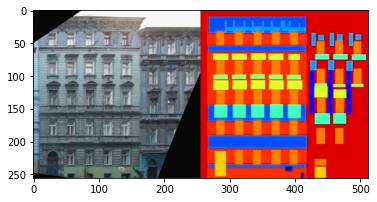

In [ ]:
plt.imshow(img)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
image_size = 256
#image_size = 128
batch_size = 1
transform = transforms.Compose([
#    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [ ]:
class PhotoMapDataset(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, _ = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        photo_image, map_image = torch.chunk(sample, chunks=2, dim=2)
        return photo_image, map_image

In [ ]:
train_dataset = PhotoMapDataset(root=os.path.join(path, "train"), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
val_dataset = PhotoMapDataset(root=os.path.join(path, "val"), transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
#test_dataset = PhotoMapDataset(root=os.path.join(path, "test"), transform=transform)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
class UnetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, isnorm=False):
        super().__init__()
        if isnorm:
            self.convs = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2),
            )
        else:
            self.convs = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.2),
            )

        
    def forward(self, x):
        out = self.convs(x)
        return out

In [ ]:
class UnetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, isnorm=False, isdrop=False):
        super().__init__()
        
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.activ = nn.ReLU()
        self.norm = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(0.5)
        self.isnorm = isnorm
        self.isdrop = isdrop
    def forward(self, x):
        x = self.deconv(x)
        if self.isnorm:
            x = self.norm(x)
        if self.isdrop:
            x = self.dropout(x)
        
        out = self.activ(x)        
        return out

In [ ]:
class Unet(nn.Module):
    def __init__(self, n_base_channels=64):
        super().__init__()
        self.down_blocks = nn.ModuleList([
            UnetDownBlock(3, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels * 2, isnorm=True),
            UnetDownBlock(n_base_channels * 2, n_base_channels * 4, isnorm=True),
            UnetDownBlock(n_base_channels * 4, n_base_channels * 8, isnorm=True),
            UnetDownBlock(n_base_channels * 8, n_base_channels * 8, isnorm=True),
            UnetDownBlock(n_base_channels * 8, n_base_channels * 8, isnorm=True),
            UnetDownBlock(n_base_channels * 8, n_base_channels * 8, isnorm=True),
            UnetDownBlock(n_base_channels * 8, n_base_channels * 8)
        ])
        self.up_blocks = nn.ModuleList([
            UnetUpBlock(n_base_channels * 8, n_base_channels * 8, isnorm=False, isdrop=True),
            UnetUpBlock(n_base_channels * 16, n_base_channels * 8, isnorm=True, isdrop=True),
            UnetUpBlock(n_base_channels * 16, n_base_channels * 8, isnorm=True, isdrop=True),
            UnetUpBlock(n_base_channels * 16, n_base_channels * 8, isnorm=True),
            UnetUpBlock(n_base_channels * 16, n_base_channels * 4, isnorm=True),
            UnetUpBlock(n_base_channels * 8, n_base_channels * 2, isnorm=True),
            UnetUpBlock(n_base_channels * 4, n_base_channels * 1, isnorm=False),
        ])
        self.final_block = nn.Sequential(
            nn.ConvTranspose2d(n_base_channels * 1, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
            
        
    def forward(self, x):
        out = x
        outputs = []
        for i, block in enumerate(self.down_blocks):
            out = block(out)
            outputs.append(out)
        for i, block in enumerate(self.up_blocks[:-1]):   
            out = block(out)
            out = torch.cat((out, outputs[-i - 2]), axis=1)

        out = self.up_blocks[-1](out)
        out = self.final_block(out)
        return out

In [ ]:
class DiscrBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, strides, padding, isnorm=False):
      super().__init__()
      if isnorm:
          self.convs = nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
              nn.BatchNorm2d(out_channels),
              nn.LeakyReLU(0.2)
          )
      else:
          self.convs = nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
              nn.LeakyReLU(0.2)
          )
  def forward(self, x):
      out = self.convs(x)
      return out



In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, n_base_channels=64, kernel_size=4, strides=2, padding=1):
        super().__init__()
        self.blocks = nn.ModuleList([
            DiscrBlock(in_channels * 2, n_base_channels, kernel_size, strides, padding),
            DiscrBlock(n_base_channels * 1, n_base_channels * 2, kernel_size, strides, padding, isnorm=True),
            DiscrBlock(n_base_channels * 2, n_base_channels * 4, kernel_size, strides, 1, isnorm=True),
            DiscrBlock(n_base_channels * 4, n_base_channels * 8, kernel_size, strides//2 , 1, isnorm=True),
            DiscrBlock(n_base_channels * 8, 1, kernel_size, strides//2, 0)
        ])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], axis=1)
        for i, block in enumerate(self.blocks):
            x = block(x)
        out = self.sigmoid(x)
        return out

In [ ]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
generator = Unet(n_base_channels=64).to(device)
discriminator = Discriminator().to(device)

In [ ]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (blocks): ModuleList(
    (0): DiscrBlock(
      (convs): Sequential(
        (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): DiscrBlock(
      (convs): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): DiscrBlock(
      (convs): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): DiscrBlock(
      (convs): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [ ]:
gen_opt = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
dis_opt = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [ ]:
def discriminator_loss(discriminator,x_real, x_fake, z):
    real_preds = discriminator(x_real, z)
    fake_preds = discriminator(x_fake, z)
    loss_D = criterion(real_preds, torch.ones_like(real_preds)) + criterion(fake_preds, torch.zeros_like(fake_preds))
    return loss_D / 2

def generator_loss(fake_preds):
    return criterion(fake_preds, torch.ones_like(fake_preds))


In [ ]:
def train_dis(discriminator, generator,x_real, z):
    x_fake=generator(z)
    dis_opt.zero_grad()
    loss_D = discriminator_loss(discriminator, x_real, x_fake, z)
    loss_D.backward()
    dis_opt.step()
    return loss_D.item()

def train_gen(discriminator, generator,x_real, z):
    x_fake=generator(z)
    gen_opt.zero_grad()
    fake_preds=discriminator(x_fake, z)
    loss_G = generator_loss(fake_preds)
    
    loss_reconstr = criterion_reconstr(x_real,x_fake)#.mean()
    loss_G += 100 * loss_reconstr
    loss_G.backward()
    gen_opt.step()
    return loss_G.item()

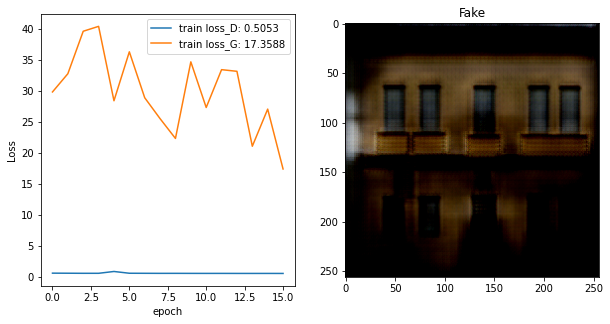

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
criterion = nn.BCEWithLogitsLoss()
criterion_reconstr = nn.L1Loss()
losses_D_hist = []
losses_G_hist = []
for epoch in range(1, 20):
    generator.train(True)
    discriminator.train(True)
    for x,z in tqdm(train_loader):
        z=z.to(device)
        x=x.to(device)
        #z=Variable(z)

        x_real=x.clone()
        for _ in range(1):
            loss_D = train_dis(discriminator, generator, x_real, z)
        loss_G = train_gen(discriminator, generator, x_real, z)
    losses_D_hist.append(loss_D)
    losses_G_hist.append(loss_G)
    clear_output(True)
    generator.eval()
    discriminator.eval()

    with torch.no_grad():
        z=val_dataset[0][1]
        z=z.to(device).unsqueeze(0)
        #z=Variable(z)
        img=generator(z)
        img=torch.clamp(img, min=0, max=1)
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.plot(losses_D_hist, label='train loss_D: {:.4f}'.format(losses_D_hist[-1]))
        plt.plot(losses_G_hist, label='train loss_G: {:.4f}'.format(losses_G_hist[-1]))
        plt.legend()
        plt.subplot(1,2,2)
        plt.title("Fake")
        plt.imshow(img.cpu().detach().numpy().transpose([0, 2, 3, 1])[0])    
        plt.show()